In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import numpy as np
import librosa
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from src.augment_lib import Rozszerzanie
from src.specaugment import SpecAugment
from src.funkcje import load_audio, mfcc, apply_spec_augment, plot_history, extract_mfcc
from sklearn.model_selection import train_test_split
print(np.__version__)

1.26.4


In [2]:
SR = 16000
DURATION = 1.0
POS_DIR = os.path.join('Nagrania', 'Hugo')
NEG_DIR = os.path.join('Nagrania', 'Negative')
OUTPUT_DIR = "processed_data"
seed = 42

In [3]:
augmenter = Rozszerzanie()
zmywanie = librosa.load(r'background\doing_the_dishes.wav', sr=SR)[0]
kran = librosa.load(r'background\running_tap.wav', sr=SR)[0]
rower = librosa.load(r'background\exercise_bike.wav', sr=SR)[0]

augmenter.add_noise_to_library('zmywanie', zmywanie)
augmenter.add_noise_to_library('rower', rower)
augmenter.add_noise_to_library('kran', kran)

c:\Users\Hubert\Desktop\Praca_dyplomowa_TensorFlow\venv\Lib\site-packages\librosa\core\intervals.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [4]:
def load_and_label():
    file_paths = []
    labels = []
    for file in os.listdir(POS_DIR):
        file_paths.append(os.path.join(POS_DIR, file))
        labels.append(1)
    for file in os.listdir(NEG_DIR):
        file_paths.append(os.path.join(NEG_DIR, file))
        labels.append(0)

    return file_paths, labels

In [5]:
def mfcc_normalization(mfccs):
    mean = tf.reduce_mean(mfccs, axis=1, keepdims=True)
    std = tf.math.reduce_std(mfccs, axis=1, keepdims=True)+1e-10
    return (mfccs - mean)/std

In [6]:
def process_data(file_paths, labels, augment=False):
    mfcc_features = []
    processed_labels = []
    n_mfcc = 20
    pos_aug_factor = 3
    neg_aug_factor = 0.1
    
    for path, label in zip(file_paths, labels):
        original_audio = load_audio(path, SR, DURATION)
        mfccs_orig = extract_mfcc(original_audio, sr=SR, n_mfcc=n_mfcc)

        mfcc_features.append(mfccs_orig)
        processed_labels.append(tf.constant(label, dtype=tf.int32))
        if augment:
            if label == 1:
                for _ in range(pos_aug_factor):
                    rand_val = random.random()

                    if rand_val < 0.4:
                        mfccs_aug, _ = apply_spec_augment(mfccs_orig, label)
                        mfcc_features.append(mfccs_aug)
                        processed_labels.append(tf.constant(label, dtype=tf.int32))

                    elif rand_val < 0.9:
                        current_audio_config = [
                            {'name': 'add_white_noise', 'p': 0.3, 'params': {'noise_factor': 0.03}},
                            {'name': 'time_stretch', 'p': 0.2, 'params': {'stretch_rate': random.uniform(0.93, 1.07), 'target_duration': DURATION}},
                            {'name': 'pitch_scale', 'p': 0.3, 'params': {'num_semitones': random.randint(-2, 2)}},
                            {'name': 'add_noise', 'p': 0.3, 'params': {
                                'noise_options': [["zmywanie", 0.4], ["kran", 0.3], ["rower", 0.3]],
                                'snr': random.randint(7, 20)}}]

                        augmented_audio, _ = augmenter.apply_augmentation(np.copy(original_audio), label, current_audio_config, debug=random.random() < 0.05)

                        mfccs_aug = extract_mfcc(augmented_audio, sr=SR, n_mfcc=n_mfcc)
                        mfcc_features.append(mfccs_aug)
                        processed_labels.append(tf.constant(label, dtype=tf.int32))
            elif label == 0 and random.random() < neg_aug_factor:
                rand_val = random.random()
                if rand_val < 0.4:
                    mfccs_aug, _ = apply_spec_augment(mfccs_orig, label)
                    mfcc_features.append(mfccs_aug)
                    processed_labels.append(tf.constant(label, dtype=tf.int32))

                elif rand_val < 0.9:
                    current_audio_config = [
                            {'name': 'add_white_noise', 'p': 0.4, 'params': {'noise_factor': 0.02}},
                            {'name': 'time_stretch', 'p': 0.4, 'params': {'stretch_rate': random.uniform(0.96, 1.03), 'target_duration': DURATION}},
                            {'name': 'pitch_scale', 'p': 0.2, 'params': {'num_semitones': random.randint(-1, 1)}}]

                    augmented_audio, _ = augmenter.apply_augmentation(np.copy(original_audio), label, current_audio_config, debug=random.random() < 0.01)
                    mfccs_aug = extract_mfcc(augmented_audio, sr=SR, n_mfcc=n_mfcc)
                    mfcc_features.append(mfccs_aug)
                    processed_labels.append(tf.constant(label, dtype=tf.int32))

    return mfcc_features, processed_labels

In [7]:
file_paths, labels = load_and_label()

In [8]:
print(file_paths[10], labels[10])

Nagrania\Hugo\hugo_108.wav 1


In [9]:
train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.3, stratify=labels, random_state=seed)

In [10]:
from sklearn.utils.class_weight import compute_class_weight
unique_labels = np.unique(train_labels)
weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_labels,
    y=train_labels  
)
# enumerate(weights) da (0, waga_dla_klasy_0), (1, waga_dla_klasy_1), itd.
class_weight_dict = dict(enumerate(weights))


In [11]:
X_train, y_train = process_data(train_paths, train_labels, augment=True)
X_test, y_test = process_data(test_paths, test_labels, augment=False)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_train), seed=seed).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
for x, y in train_dataset.take(10):
    print(x.shape)


(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)


In [14]:
from keras.api import layers, models, activations, optimizers, regularizers, Input, utils, callbacks, losses, metrics
from models.models import crnn, resnet8, resnet14, MatchboxNet
input_shape = (X_train[0].shape[0], X_train[0].shape[1])


In [15]:
model_crnn = crnn(input_shape, num_classes=1, k=1.5)
model_crnn.summary()

Model: "CRNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 98, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 98, 48)         │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 48)         │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 98, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 49, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 96)             │        42,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,209 (196.13 KB)

 Trainable params: 49,921 (195.00 KB)

 Non-trainable params: 288 (1.12 KB)

In [16]:
model_resnet8 = resnet8(input_shape, num_classes=1, k=1.5)
model_resnet8.summary()
model_resnet14 = resnet14(input_shape, num_classes=1, k=1.5)
model_resnet14.summary()

Model: "ResNet8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 98, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 98, 24)    │        480 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 98, 24)    │         96 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 98, 24)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 49, 36)    │      2,592 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 49, 36)    │        864 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 49, 36)    │      3,888 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 49, 36)    │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 49, 36)    │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 49, 36)    │          0 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 25, 48)    │      5,184 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 48)    │        192 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 25, 48)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 25, 48)    │      1,728 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 25, 48)    │      6,912 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 48)    │        192 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 60,097 (234.75 KB)

 Trainable params: 59,113 (230.91 KB)

 Non-trainable params: 984 (3.84 KB)

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 98, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 98, 24)    │      1,440 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 98, 24)    │         96 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 98, 24)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 49, 36)    │      2,592 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 49, 36)    │        864 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 49, 36)    │      3,888 │ re_lu_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 49, 36)    │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 49, 36)    │          0 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 49, 36)    │          0 │ re_lu_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 49, 36)    │      3,888 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 49, 36)    │      3,888 │ re_lu_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 49, 36)    │          0 │ batch_normalizat

 Total params: 140,545 (549.00 KB)

 Trainable params: 138,937 (542.72 KB)

 Non-trainable params: 1,608 (6.28 KB)

In [17]:
model_matchboxnet = MatchboxNet(input_shape, num_classes=1, B=3, R=1, C=64)
model_matchboxnet.summary()

Model: "MatchboxNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 98, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalization │ (None, 98, 20)    │         40 │ input_layer_3[0]… │
│ (GroupNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 49, 128)   │     28,288 │ group_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 128)   │        512 │ conv1d_27[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 49, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d    │ (None, 49, 64)    │      9,920 │ re_lu_24[0][0]    │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 49, 64)    │      8,256 │ re_lu_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 64)    │        256 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 64)    │        256 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 49, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 49, 64)    │          0 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 49, 64)    │          0 │ re_lu_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_1  │ (None, 49, 64)    │      5,120 │ dropout_17[0][0]  │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 49, 64)    │      4,160 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 64)    │        256 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 64)    │        256 │ conv1d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 49, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 49, 64)    │          0 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 49, 64)    │          0 │ re_lu_26[0][0]  

 Total params: 322,601 (1.23 MB)

 Trainable params: 321,065 (1.22 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - Precision: 0.4503 - Recall: 0.5209 - accuracy: 0.6838 - auc: 0.7030 - loss: 0.7724
Epoch 1: val_auc improved from -inf to 0.93308, saving model to trained_models_wake_word\crnn_wake_word.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - Precision: 0.4509 - Recall: 0.5213 - accuracy: 0.6842 - auc: 0.7036 - loss: 0.7717 - val_Precision: 0.7386 - val_Recall: 0.3736 - val_accuracy: 0.9233 - val_auc: 0.9331 - val_loss: 0.3635 - learning_rate: 5.0000e-04
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - Precision: 0.7032 - Recall: 0.7205 - accuracy: 0.8404 - auc: 0.9026 - loss: 0.4993
Epoch 2: val_auc improved from 0.93308 to 0.96955, saving model to trained_models_wake_word\crnn_wake_word.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - Precision: 0.7033 - Recall: 0.7207 - accuracy: 0.8405 - auc: 0.9027 - loss: 0.4991 - val_Precision: 0.6968 - val_Recall: 0.7529 - val_accuracy: 0.9419 - val_auc: 0.9695 - val_loss: 0.2713 - learn

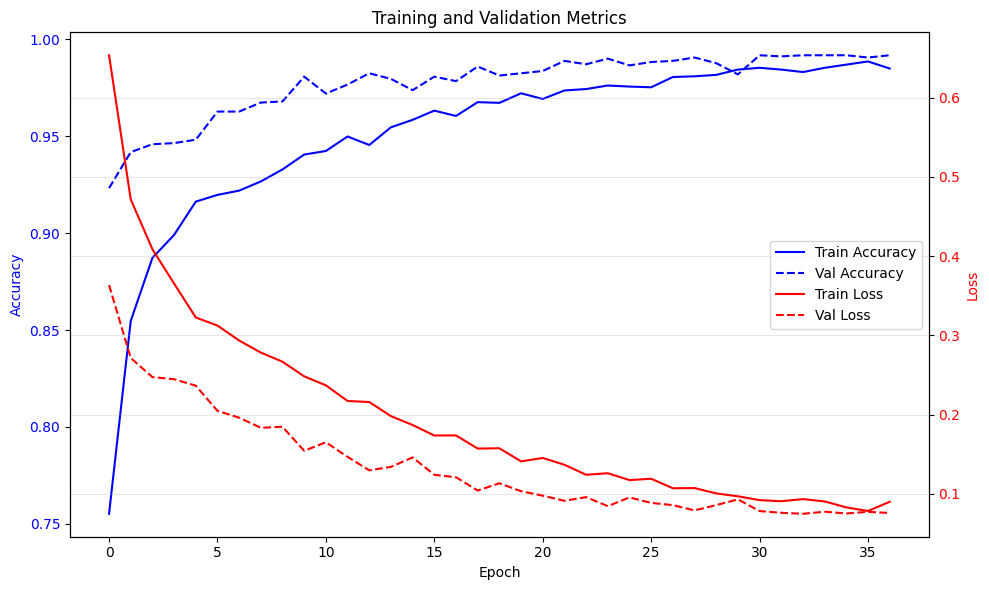

In [18]:
model_crnn.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.AUC(name='auc')])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath=r'trained_models_wake_word\crnn_wake_word.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

crnn_history = model_crnn.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr]   )
plot_history(crnn_history)

Epoch 1/100
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.5742 - Recall: 0.5009 - accuracy: 0.7655 - auc: 0.8073 - loss: 0.9519
Epoch 1: val_auc improved from -inf to 0.97068, saving model to trained_models_wake_word\resnet8_wake_word.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - Precision: 0.5756 - Recall: 0.5028 - accuracy: 0.7662 - auc: 0.8083 - loss: 0.9506 - val_Precision: 0.3048 - val_Recall: 0.9828 - val_accuracy: 0.7715 - val_auc: 0.9707 - val_loss: 0.8957 - learning_rate: 5.0000e-04
Epoch 2/100
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.8118 - Recall: 0.8256 - accuracy: 0.9013 - auc: 0.9570 - loss: 0.6784
Epoch 2: val_auc improved from 0.97068 to 0.98676, saving model to trained_models_wake_word\resnet8_wake_word.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - Precision: 0.8120 - Recall: 0.8259 - accuracy: 0.9014 - auc: 0.9570 - loss: 0.6781 - val_Precision: 0.5611 - val_Recall: 0.9770 - val_accuracy: 0.9203 - val_auc: 0.9868 - val_loss: 0.5987 - le

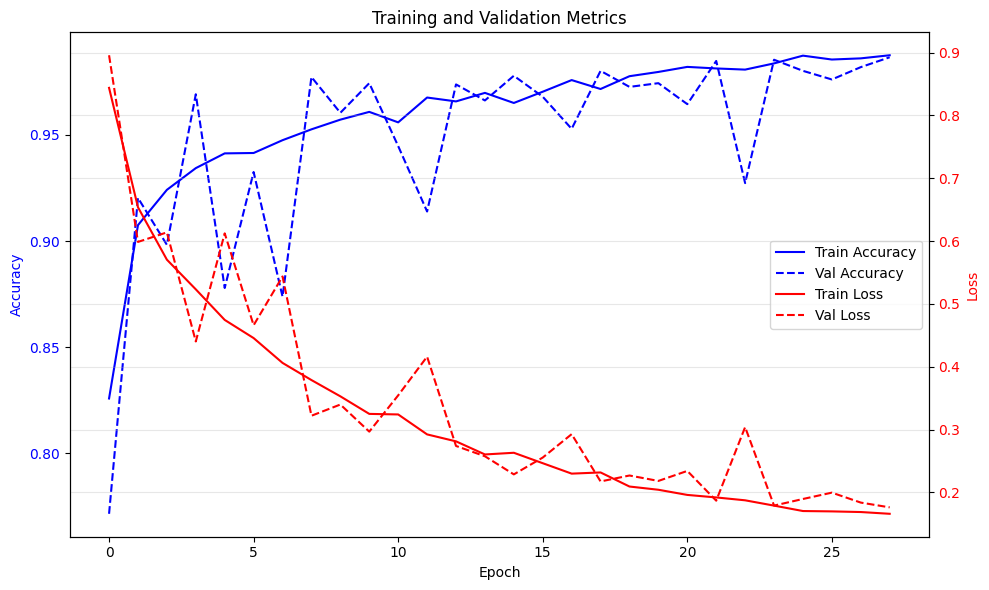

In [19]:
model_resnet8.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.AUC(name='auc')])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath=r'trained_models_wake_word\resnet8_wake_word.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

resnet8_history = model_resnet8.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr]   )
plot_history(resnet8_history)

Epoch 1/100


171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - Precision: 0.5597 - Recall: 0.3543 - accuracy: 0.7324 - auc: 0.7548 - loss: 1.4347
Epoch 1: val_auc improved from -inf to 0.96336, saving model to trained_models_wake_word\resnet14_wake_word.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - Precision: 0.5605 - Recall: 0.3557 - accuracy: 0.7329 - auc: 0.7555 - loss: 1.4338 - val_Precision: 0.2430 - val_Recall: 0.9943 - val_accuracy: 0.6860 - val_auc: 0.9634 - val_loss: 1.3804 - learning_rate: 5.0000e-04
Epoch 2/100
167/171 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - Precision: 0.7461 - Recall: 0.8330 - accuracy: 0.8758 - auc: 0.9375 - loss: 1.0775
Epoch 2: val_auc improved from 0.96336 to 0.98128, saving model to trained_models_wake_word\resnet14_wake_word.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - Precision: 0.7470 - Recall: 0.8329 - accuracy: 0.8761 - auc: 0.9378 - loss: 1.0760 - val_Precision: 0.3209 - val_Recall: 0.9885 - val_accuracy: 0.7872 - val_auc: 0.9813 - val_loss: 1.2201 - learning

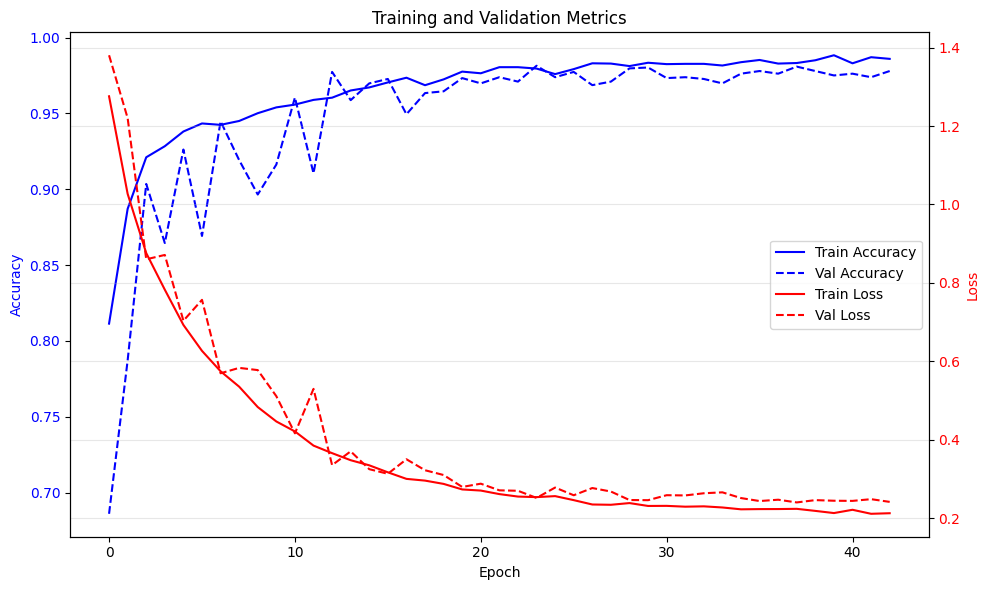

In [20]:
model_resnet14.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.AUC(name='auc')])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath=r'trained_models_wake_word\resnet14_wake_word.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

resnet14_history = model_resnet14.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr]    )
plot_history(resnet14_history)

Epoch 1/100


171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - Precision: 0.7713 - Recall: 0.8956 - accuracy: 0.8903 - auc: 0.9487 - loss: 0.2948
Epoch 1: val_auc improved from -inf to 0.99155, saving model to trained_models_wake_word\matchboxnet_wake_word.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - Precision: 0.7718 - Recall: 0.8957 - accuracy: 0.8905 - auc: 0.9488 - loss: 0.2942 - val_Precision: 0.2231 - val_Recall: 1.0000 - val_accuracy: 0.6477 - val_auc: 0.9916 - val_loss: 0.6360 - learning_rate: 5.0000e-04
Epoch 2/100
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - Precision: 0.9334 - Recall: 0.9458 - accuracy: 0.9677 - auc: 0.9926 - loss: 0.0956
Epoch 2: val_auc did not improve from 0.99155
171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - Precision: 0.9336 - Recall: 0.9458 - accuracy: 0.9677 - auc: 0.9926 - loss: 0.0955 - val_Precision: 0.2302 - val_Recall: 1.0000 - val_accuracy: 0.6616 - val_auc: 0.9911 - val_loss: 0.7725 - learning_rate: 5.0000e-04
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/s

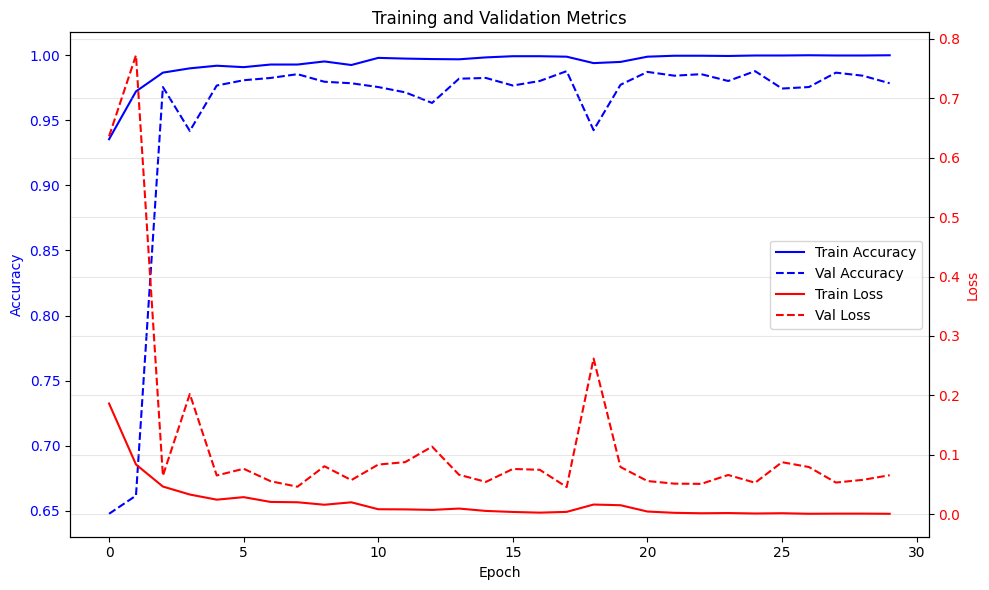

In [21]:
model_matchboxnet.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.AUC(name='auc')])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath=r'trained_models_wake_word\matchboxnet_wake_word.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

matchboxnet_history = model_matchboxnet.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr]   )
plot_history(matchboxnet_history)